In [18]:
import torch
import torch.nn as nn
from torchvision import datasets,transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as F

In [19]:
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
from dataclasses import dataclass

import torch


@dataclass
class VAEOutput:
    """
    Dataclass for VAE output.
    
    Attributes:
        z_dist (torch.distributions.Distribution): The distribution of the latent variable z.
        z_sample (torch.Tensor): The sampled value of the latent variable z.
        x_recon (torch.Tensor): The reconstructed output from the VAE.
        loss (torch.Tensor): The overall loss of the VAE.
        loss_recon (torch.Tensor): The reconstruction loss component of the VAE loss.
        loss_kl (torch.Tensor): The KL divergence component of the VAE loss.
    """
    z_dist: torch.distributions.Distribution
    z_sample: torch.Tensor
    x_recon: torch.Tensor
    
    loss: torch.Tensor
    loss_recon: torch.Tensor
    loss_kl: torch.Tensor

class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) class

    Args:
        input_dim(int): Dimensionality of the input data.
        hidden_dim(int): Dimensionality of the hidden layer.
        latent_dim(int): Dimensionality of the latent space.
    """

    def __init__(self, input_dim,hidden_dim,latent_dim):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(), # Swish activation function
            nn.Linear(hidden_dim,hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.SiLU(),
            nn.Linear(hidden_dim // 4, hidden_dim // 8),
            nn.SiLU(),
            nn.Linear(hidden_dim // 8, 2 * latent_dim), # 2 for mean and variance.
        )
        self.softplus = nn.Softplus()

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 8),
            nn.SiLU(),
            nn.Linear(hidden_dim // 8, hidden_dim // 4),
            nn.SiLU(),
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim,input_dim),
            nn.Sigmoid(),
        )

    def encode(self,x,eps:float=1e-8):
        """
        Encodes the input data into the latent space
        
        Args:
            x (torch.Tensor): input data.
            eps (float): Small value to avoid numerical instability
        
        Returns:
            torch.distributions.MultivariateNormal:Normal distribution of the encoded data.
        """
        x = self.encoder(x)
        mu, logvar = torch.chunk(x,2,dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)

        return torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)

    def reparameterize(self,dist):
        """
        Reparameterizes the encoded data to sample from the latent space

        Args:
            dist (torch.distributions.MultivariateNormal): Normal distributions of the encoded data.
        
        Returns:
            torch.Tensor: Sampled data from the latent space.
        """
        return dist.rsample()
    
    def decode(self, z):
        """
        Decodes the data from the latent space to the original input space.

        Args:
            z(torch.Tensor): Data in the latent space.
        
        Returns:
            torch.Tensor: Reconstructed data in the original input space.
        """

        return self.decoder(z)
    
    def forward(self, x, compute_loss:bool=True):
        """
        Performs a forwad pass of the VAE.

        Args:
            x(torch.Tensor):Input data.
            compute_loss(bool): whether to compute the loss or not
        
        Returns:
            VAEOutput: VAE output dataclass.
        """
        dist = self.encode(x)
        z = self.reparameterize(dist)
        recon_x = self.decode(z)

        if not compute_loss:
            return VAEOutput(
                z_dist=dist,
                z_sample=z,
                x_recon=recon_x,
                loss=None,
                loss_recon=None,
                loss_kl=None,
            )
        loss_recon = F.binary_cross_entropy(recon_x,x+0.5, reduction='none').sum(-1).mean()
        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril = torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0],-1,-1),
        )
        loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal).mean()

        loss = loss_recon + loss_kl

        return VAEOutput(
            z_dist=dist,
            z_sample=z,
            x_recon=recon_x,
            loss=loss,
            loss_recon=loss_recon,
            loss_kl=loss_kl,
        )
  
 

In [6]:
torch.chunk(torch.rand(2,2),2,dim=-1)

(tensor([[0.3759],
         [0.2769]]),
 tensor([[0.1712],
         [0.9316]]))

### 1. **为什么 `nn.Sequential` 的最后一层是 `2 * latent_dim`？**

在 Variational Autoencoder (VAE) 中，**编码器**的目标是从输入数据中学习到潜在空间的分布。VAE 使用 **重参数化技巧** 来使得模型能够从一个分布中采样潜在变量 \( z \)，而这个分布由均值（mean）和方差（variance）决定。

- **均值（mean）**：潜在空间中每个维度的中心位置。
- **方差（variance）**：潜在空间中每个维度的散布程度。

因此，编码器的最后一层输出的 **2 * latent_dim** 向量分为两部分：
- **前 latent_dim** 个元素对应 **均值**（mean）。
- **后 latent_dim** 个元素对应 **对数方差**（log variance），即方差的对数。使用对数变换可以确保方差为正，避免负方差的情况发生。

也就是说，最后一层输出的 2 * latent_dim 向量中：
- 第一部分：表示潜在空间的每个维度的均值。
- 第二部分：表示潜在空间的每个维度的对数方差。

在进行重参数化时，模型会利用这两个输出值（均值和方差）来构建潜在变量的分布，然后从这个分布中进行采样。通过这样的方式，VAE 可以在训练过程中进行梯度传播。

### 2. **`Softplus` 是什么，它和 `Softmax` 有什么区别？**

#### **Softplus 激活函数：**

`Softplus` 是一种平滑的 ReLU 激活函数，其定义为：

\[
\text{Softplus}(x) = \log(1 + e^x)
\]

它的作用是将输入映射到一个平滑的非负值，使得对于负输入，输出逐渐趋近于零，而对于正输入，输出会逐渐线性增长。相比于 ReLU，Softplus 提供了更平滑的梯度，因此有时在训练过程中会带来更稳定的行为。

在 VAE 中，`Softplus` 通常用于对 **对数方差**（log variance）进行平滑变换，确保方差为正。它的作用是：
- **对数方差** 是在编码器的输出中生成的，而我们希望最终得到的是正的方差值。`Softplus` 可以保证输出的方差始终为正，因为它将对数值映射到正值空间。

#### **Softmax 激活函数：**

`Softmax` 是另一种常见的激活函数，它将一个向量中的每个元素映射到一个概率分布。其定义为：

\[
\text{Softmax}(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}}
\]

`Softmax` 主要用于分类任务，特别是在神经网络的输出层，用来生成多类别的概率分布。其作用是：
- 将输入的每个元素转换为一个0到1之间的值，且所有输出值的和为1，这样每个输出值可以解释为属于某个类别的概率。

### **区别总结：**

- **Softplus** 是一种平滑的 ReLU 激活函数，通常用于确保输出始终为正，尤其是在处理方差（log variance）等需要正值的情况中。它将输入变换为正数，避免了像 ReLU 那样的死区问题（负数部分为零）。
- **Softmax** 主要用于生成概率分布，它将输入映射到 \(0\) 到 \(1\) 之间，并且所有输出的和为 1，适用于多分类问题的输出层。

#### 主要区别：
- **Softplus** 是用于平滑的激活函数，确保输出为正，通常在连续值或回归任务中使用。
- **Softmax** 是用于归一化的激活函数，输出值表示类别的概率，常用于分类问题的输出层。

是的，你的理解是对的！如果我们在 VAE 中选择不同的分布作为潜在空间（latent space）的分布，输出的形式和维度也会有所不同，具体的结构会依赖于选择的分布类型。

### **关于 VAE 和潜在分布的说明**

VAE 的核心思想是通过学习一个 **近似后验分布** \( q(z|x) \)，然后在这个分布中进行重参数化，以便能够从中进行采样并进行反向传播。

- **标准正态分布（Gaussian）**：VAE 中常用的分布是 **正态分布**，即假设潜在变量 \( z \) 服从一个 **多维标准正态分布**（均值为 0，方差为 1），或者是具有均值和方差（log variance）可学习的正态分布。
  - 这种情况下，编码器输出 **2 * latent_dim**：一半用于均值 \( \mu \)，另一半用于对数方差 \( \log(\sigma^2) \)。

### **如果我们换成其他分布，比如二项分布（Binomial）**

如果你选择其他类型的分布来作为潜在空间的分布，比如 **二项分布（Binomial Distribution）** 或 **零膨胀二项分布（ZINB, Zero-Inflated Negative Binomial）**，那么编码器的最后一层输出的结构和维度会有所变化，因为你需要根据选择的分布来调整模型的参数。

#### **例如，零膨胀二项分布（ZINB）**：

ZINB 是一种常用的分布，特别是在处理稀疏数据（比如在自然语言处理和基因数据中常见的稀疏表示）时。它通常由两个部分组成：
1. **零膨胀部分**：决定数据是否为零。
2. **负二项分布部分**：如果数据不是零，则服从负二项分布。

**ZINB 的参数**通常包括：
- **\( p \)**：零膨胀的概率（表示数据为零的概率）。
- **\( r \)** 和 **\( \theta \)**：负二项分布的参数（通常是成功次数和成功的概率）。

如果你用 ZINB 作为潜在分布，编码器的最后一层输出可能需要：
- **1 个输出值**用于表示零膨胀的概率 \( p \)（可能是通过 Sigmoid 激活函数得到的）。
- **2 个输出值**用于表示负二项分布的参数 \( r \) 和 \( \theta \)。

所以，你的网络最后一层的输出维度将变为 **3 * latent_dim**，即：
- 第一部分：零膨胀概率 \( p \)。
- 第二部分：负二项分布的参数 \( r \) 和 \( \theta \)。

这就与标准的正态分布不同了，因为对于正态分布，我们只需要输出均值和对数方差，而对于 ZINB，我们需要为零膨胀和负二项分布的参数提供不同的输出。

### **总结**

- **正态分布**：通常，VAE 的潜在空间使用正态分布，输出 **2 * latent_dim**：均值和对数方差。
- **其他分布（如 ZINB）**：如果使用其他分布，最后一层的输出维度会增加，具体取决于所选分布的参数数量。例如，ZINB 可能需要 **3 * latent_dim** 的输出维度，分别对应零膨胀概率和负二项分布的参数。

因此，潜在层的输出维度和结构会根据所选的分布而变化。你需要根据分布的性质和参数要求调整编码器最后一层的输出维度，以便适应新的分布。

In [22]:
batch_size = 128
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32,scale=True),
    v2.Lambda(lambda x: x.view(-1) - 0.5),
])

train_data = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=True)

在你提供的代码中，`v2` 代表的是 **`torchvision.transforms`** 的第二版（`v2`），是 `torchvision` 库的一个较新的版本，通常包括一些新的功能和接口改进。`transforms` 是早期版本的命名空间，它包含了用于图像预处理的各种转换操作（如归一化、随机裁剪、旋转等）。从 `torchvision` 版本 0.12 起，官方开始引入 `v2` 版本，并对很多转换操作进行了重构。

### **`v2` 和 `transforms` 的区别**

- **`transforms`**：在早期的 `torchvision` 版本中使用的命名空间，包含了一些经典的图像处理变换，如 `ToTensor`、`Normalize` 等。
- **`v2`**：在较新的 `torchvision` 版本中使用的命名空间，包含了更新的 API。`v2` 引入了更加灵活和一致的转换方法，允许通过链式操作（`Compose`）更加方便地定义数据预处理流程，提升了性能和可扩展性。

简而言之，`v2` 是 `torchvision.transforms` 的更新版本，它引入了更多的改进和功能，可能与旧版 `transforms` 有一些细微差别。

### **`v2.Compose` 的标准化流程**

在代码中，你使用了 `v2.Compose` 来组合多个图像转换操作。下面是每个步骤的详细解释：

```python
transform = v2.Compose([
    v2.ToImage(),  # 将输入图像转换为标准图像格式
    v2.ToDtype(torch.float32, scale=True),  # 转换数据类型为 float32，并归一化到 [0, 1] 范围
    v2.Lambda(lambda x: x.view(-1) - 0.5),  # 将图像展平并进行零中心化处理
])
```

1. **`v2.ToImage()`**：
   - 将输入转换为图像格式。这个转换操作确保了输入数据符合图像格式，适用于从不同格式的数据（如 numpy 数组、PIL 图像等）转换为统一的图像格式。

2. **`v2.ToDtype(torch.float32, scale=True)`**：
   - 将图像转换为 `float32` 类型，并且通过 `scale=True` 自动将图像的像素值归一化到 `[0, 1]` 范围。
   - 在 MNIST 数据集中，像素值范围原本是 `[0, 255]`，通过这一步转换，图像的像素值将变为 `[0.0, 1.0]`。
   
3. **`v2.Lambda(lambda x: x.view(-1) - 0.5)`**：
   - `x.view(-1)` 将图像展平（将二维图像转化为一维向量）。
   - `- 0.5` 对每个像素值进行零中心化处理，即将像素值从 `[0, 1]` 范围调整到 `[-0.5, 0.5]`。这是为了帮助神经网络更好地学习，因为在 `[-0.5, 0.5]` 范围内，数据的分布中心是 0，这通常能加速训练并提高收敛速度。

### **标准化流程总结**

- **归一化（Normalization）**：首先，`v2.ToDtype(torch.float32, scale=True)` 将数据从 `[0, 255]` 范围归一化到 `[0, 1]` 范围。
- **零中心化（Zero-Centering）**：接着，`v2.Lambda(lambda x: x.view(-1) - 0.5)` 将归一化后的数据从 `[0, 1]` 范围平移到 `[-0.5, 0.5]`，即进行零中心化。
- **展平（Flatten）**：`x.view(-1)` 使得每张图像的像素值被展平成一个一维的向量，这对于后续的全连接层（fully connected layer）等操作非常有用。

这种标准化流程对训练深度学习模型特别重要，零中心化可以让模型的训练过程更稳定、收敛更快。

In [23]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 50
latent_dim = 2
hidden_dim = 512

model = VAE(input_dim=784,hidden_dim=hidden_dim,latent_dim=latent_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
writer = SummaryWriter(f'runs/mnist/vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

In [13]:
from tqdm import tqdm
def train(model, dataloader, optimizer, prev_updates, writer=None):
    """
    Train the model on the given data.

    Args:
        model(nn.Module): The model to train
        dataloader(torch.utils.data.DataLoader): The data loader
        loss_fn:The loss function
        optimizer: the optimizer
    """
    model.train() # Set the model to training mode
    for batch_idx, (data,target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        data = data.to(device)
        optimizer.zero_grad() # zero the gradients
        output = model(data)
        loss = output.loss
        loss.backward()
        if n_upd % 100 == 0:
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)

            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) Grad: {total_norm:.4f}')        

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', output.loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', output.loss_kl.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
        
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

    return prev_updates + len(dataloader)


In [26]:
def test(model,dataloader,cur_step,writer=None):
    """
    Tests the model on the given data

    Args:
        model(nn.Module): The model to test
        dataloader: The data loader
        cur_step(int):The current step
        writer:Teh TensorBoard writer
    """
    model.eval() # Set the model to evalution mode
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0

    with torch.no_grad():
        for data, target in tqdm(dataloader, desc="Testing"):
            data = data.to(device)
            data = data.view(data.size(0), -1) # Flatten the data

            output = model(data, compute_loss=True) # Forwad pass

            test_loss += output.loss.item()
            test_recon_loss += output.loss_recon.item()
            test_kl_loss += output.loss_kl.item()

    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f})')

    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', output.loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', output.loss_kl.item(), global_step=cur_step)
        
        # Log reconstructions
        writer.add_images('Test/Reconstructions', output.x_recon.view(-1, 1, 28, 28), global_step=cur_step)
        writer.add_images('Test/Originals', data.view(-1, 1, 28, 28), global_step=cur_step)
        
        # Log random samples from the latent space
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decode(z)
        writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [27]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model,test_loader,prev_updates,writer=writer)

Epoch 1/50


  0%|          | 2/469 [00:00<00:25, 18.08it/s]

Step 0 (N samples: 0), Loss: 181.7128 (Recon: 178.6603, KL: 3.0525) Grad: 34.4144


 23%|██▎       | 110/469 [00:01<00:05, 71.02it/s]

Step 100 (N samples: 12,800), Loss: 168.4369 (Recon: 165.2820, KL: 3.1549) Grad: 56.9685


 45%|████▍     | 211/469 [00:03<00:03, 70.08it/s]

Step 200 (N samples: 25,600), Loss: 185.2482 (Recon: 181.5314, KL: 3.7168) Grad: 45.6059


 67%|██████▋   | 312/469 [00:04<00:02, 72.25it/s]

Step 300 (N samples: 38,400), Loss: 176.1905 (Recon: 171.9602, KL: 4.2303) Grad: 92.9642


 87%|████████▋ | 408/469 [00:05<00:00, 68.84it/s]

Step 400 (N samples: 51,200), Loss: 165.4664 (Recon: 161.1755, KL: 4.2909) Grad: 40.3385


Testing: 100%|██████████| 79/79 [00:01<00:00, 75.12it/s]


====> Test set loss: 175.7222 (BCE: 171.4721, KLD: 4.2501)
Epoch 2/50


  9%|▉         | 43/469 [00:00<00:06, 69.08it/s]

Step 500 (N samples: 64,000), Loss: 171.8786 (Recon: 167.4848, KL: 4.3937) Grad: 64.1851


 29%|██▉       | 138/469 [00:02<00:05, 64.28it/s]

Step 600 (N samples: 76,800), Loss: 167.5515 (Recon: 162.5081, KL: 5.0434) Grad: 67.3669


 51%|█████     | 239/469 [00:04<00:04, 48.64it/s]

Step 700 (N samples: 89,600), Loss: 163.1238 (Recon: 157.8061, KL: 5.3177) Grad: 85.4490


 72%|███████▏  | 340/469 [00:05<00:01, 67.46it/s]

Step 800 (N samples: 102,400), Loss: 163.7746 (Recon: 158.4001, KL: 5.3745) Grad: 123.4396


 93%|█████████▎| 437/469 [00:07<00:00, 47.21it/s]

Step 900 (N samples: 115,200), Loss: 161.6622 (Recon: 156.1501, KL: 5.5121) Grad: 31.5859


Testing: 100%|██████████| 79/79 [00:01<00:00, 75.65it/s]


====> Test set loss: 157.6765 (BCE: 152.0153, KLD: 5.6613)
Epoch 3/50


 16%|█▌        | 73/469 [00:01<00:06, 62.86it/s]

Step 1,000 (N samples: 128,000), Loss: 151.1437 (Recon: 145.5638, KL: 5.5800) Grad: 85.4606


 37%|███▋      | 173/469 [00:02<00:04, 65.99it/s]

Step 1,100 (N samples: 140,800), Loss: 151.7480 (Recon: 146.1973, KL: 5.5508) Grad: 96.0152


 58%|█████▊    | 271/469 [00:04<00:03, 59.36it/s]

Step 1,200 (N samples: 153,600), Loss: 154.4771 (Recon: 148.9212, KL: 5.5559) Grad: 95.5132


 79%|███████▉  | 371/469 [00:05<00:01, 73.15it/s]

Step 1,300 (N samples: 166,400), Loss: 155.0301 (Recon: 149.4925, KL: 5.5376) Grad: 76.7181


100%|██████████| 469/469 [00:07<00:00, 65.08it/s]


Step 1,400 (N samples: 179,200), Loss: 150.8142 (Recon: 145.1823, KL: 5.6319) Grad: 116.7876


Testing: 100%|██████████| 79/79 [00:01<00:00, 78.24it/s]


====> Test set loss: 153.3110 (BCE: 147.5680, KLD: 5.7430)
Epoch 4/50


 23%|██▎       | 108/469 [00:01<00:05, 69.87it/s]

Step 1,500 (N samples: 192,000), Loss: 157.8203 (Recon: 152.4320, KL: 5.3883) Grad: 97.0456


 43%|████▎     | 203/469 [00:02<00:03, 71.13it/s]

Step 1,600 (N samples: 204,800), Loss: 151.0114 (Recon: 145.1276, KL: 5.8837) Grad: 205.6585


 65%|██████▍   | 304/469 [00:04<00:02, 68.72it/s]

Step 1,700 (N samples: 217,600), Loss: 146.4611 (Recon: 140.7398, KL: 5.7212) Grad: 153.7238


 86%|████████▌ | 402/469 [00:05<00:01, 66.80it/s]

Step 1,800 (N samples: 230,400), Loss: 153.6798 (Recon: 147.9549, KL: 5.7249) Grad: 241.6351


Testing: 100%|██████████| 79/79 [00:01<00:00, 76.84it/s]


====> Test set loss: 150.7494 (BCE: 144.9042, KLD: 5.8452)
Epoch 5/50


  8%|▊         | 36/469 [00:00<00:07, 55.91it/s]

Step 1,900 (N samples: 243,200), Loss: 144.3716 (Recon: 138.2769, KL: 6.0947) Grad: 100.2534


 29%|██▊       | 134/469 [00:02<00:05, 63.77it/s]

Step 2,000 (N samples: 256,000), Loss: 147.3448 (Recon: 141.5843, KL: 5.7606) Grad: 89.3598


 50%|█████     | 236/469 [00:03<00:03, 63.01it/s]

Step 2,100 (N samples: 268,800), Loss: 154.5263 (Recon: 148.8653, KL: 5.6610) Grad: 125.9163


 71%|███████   | 332/469 [00:05<00:02, 61.74it/s]

Step 2,200 (N samples: 281,600), Loss: 149.1089 (Recon: 143.0913, KL: 6.0176) Grad: 79.1905


 92%|█████████▏| 431/469 [00:07<00:00, 47.27it/s]

Step 2,300 (N samples: 294,400), Loss: 146.1278 (Recon: 140.2635, KL: 5.8643) Grad: 109.0972


Testing: 100%|██████████| 79/79 [00:01<00:00, 50.59it/s]


====> Test set loss: 155.1118 (BCE: 149.1350, KLD: 5.9768)
Epoch 6/50


 14%|█▍        | 66/469 [00:01<00:06, 59.88it/s]

Step 2,400 (N samples: 307,200), Loss: 152.0184 (Recon: 146.0840, KL: 5.9344) Grad: 121.5658


 35%|███▌      | 165/469 [00:02<00:04, 62.12it/s]

Step 2,500 (N samples: 320,000), Loss: 153.9035 (Recon: 148.0120, KL: 5.8915) Grad: 89.1267


 56%|█████▌    | 262/469 [00:04<00:02, 69.90it/s]

Step 2,600 (N samples: 332,800), Loss: 145.1514 (Recon: 139.0097, KL: 6.1417) Grad: 92.1684


 77%|███████▋  | 360/469 [00:06<00:03, 27.46it/s]

Step 2,700 (N samples: 345,600), Loss: 158.7341 (Recon: 152.8521, KL: 5.8820) Grad: 162.8622


 98%|█████████▊| 459/469 [00:10<00:00, 27.15it/s]

Step 2,800 (N samples: 358,400), Loss: 148.6887 (Recon: 142.5859, KL: 6.1028) Grad: 129.7603


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.47it/s]


====> Test set loss: 147.3602 (BCE: 141.1678, KLD: 6.1924)
Epoch 7/50


 19%|█▉        | 91/469 [00:03<00:14, 26.17it/s]

Step 2,900 (N samples: 371,200), Loss: 155.5966 (Recon: 149.6757, KL: 5.9210) Grad: 169.1405


 41%|████      | 191/469 [00:07<00:10, 26.26it/s]

Step 3,000 (N samples: 384,000), Loss: 145.0508 (Recon: 139.2101, KL: 5.8406) Grad: 175.3316


 62%|██████▏   | 291/469 [00:10<00:06, 26.41it/s]

Step 3,100 (N samples: 396,800), Loss: 142.4335 (Recon: 136.4167, KL: 6.0168) Grad: 92.6280


 83%|████████▎ | 391/469 [00:14<00:02, 26.18it/s]

Step 3,200 (N samples: 409,600), Loss: 146.5944 (Recon: 140.4519, KL: 6.1424) Grad: 137.9499


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.39it/s]


====> Test set loss: 146.3340 (BCE: 140.0414, KLD: 6.2926)
Epoch 8/50


  4%|▍         | 21/469 [00:00<00:16, 26.59it/s]

Step 3,300 (N samples: 422,400), Loss: 143.3367 (Recon: 137.0928, KL: 6.2439) Grad: 113.9265


 26%|██▌       | 123/469 [00:04<00:12, 26.71it/s]

Step 3,400 (N samples: 435,200), Loss: 146.5749 (Recon: 140.4833, KL: 6.0916) Grad: 79.4057


 47%|████▋     | 221/469 [00:08<00:09, 26.48it/s]

Step 3,500 (N samples: 448,000), Loss: 141.3121 (Recon: 135.2363, KL: 6.0759) Grad: 89.1647


 68%|██████▊   | 321/469 [00:11<00:05, 26.47it/s]

Step 3,600 (N samples: 460,800), Loss: 151.8616 (Recon: 145.5932, KL: 6.2684) Grad: 267.0107


 90%|████████▉ | 420/469 [00:15<00:01, 26.83it/s]

Step 3,700 (N samples: 473,600), Loss: 151.3661 (Recon: 144.9310, KL: 6.4351) Grad: 236.3901


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.29it/s]


====> Test set loss: 150.4332 (BCE: 144.2954, KLD: 6.1379)
Epoch 9/50


 11%|█         | 52/469 [00:01<00:15, 26.82it/s]

Step 3,800 (N samples: 486,400), Loss: 153.4022 (Recon: 147.3986, KL: 6.0036) Grad: 103.9666


 32%|███▏      | 151/469 [00:05<00:12, 26.46it/s]

Step 3,900 (N samples: 499,200), Loss: 156.3186 (Recon: 150.3227, KL: 5.9959) Grad: 120.8042


 54%|█████▎    | 252/469 [00:09<00:07, 27.83it/s]

Step 4,000 (N samples: 512,000), Loss: 147.0707 (Recon: 140.9694, KL: 6.1013) Grad: 152.2357


 75%|███████▌  | 354/469 [00:13<00:04, 27.08it/s]

Step 4,100 (N samples: 524,800), Loss: 152.8269 (Recon: 146.6005, KL: 6.2263) Grad: 88.2370


 97%|█████████▋| 453/469 [00:16<00:00, 26.95it/s]

Step 4,200 (N samples: 537,600), Loss: 141.5214 (Recon: 135.0523, KL: 6.4691) Grad: 98.4624


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.27it/s]


====> Test set loss: 147.5829 (BCE: 141.1549, KLD: 6.4280)
Epoch 10/50


 18%|█▊        | 85/469 [00:03<00:14, 26.69it/s]

Step 4,300 (N samples: 550,400), Loss: 148.7732 (Recon: 142.2520, KL: 6.5212) Grad: 264.1505


 39%|███▉      | 184/469 [00:06<00:10, 26.81it/s]

Step 4,400 (N samples: 563,200), Loss: 155.5480 (Recon: 149.2308, KL: 6.3172) Grad: 149.7308


 60%|██████    | 283/469 [00:10<00:06, 27.25it/s]

Step 4,500 (N samples: 576,000), Loss: 139.9070 (Recon: 133.6472, KL: 6.2598) Grad: 112.9248


 82%|████████▏ | 383/469 [00:14<00:03, 26.75it/s]

Step 4,600 (N samples: 588,800), Loss: 156.5922 (Recon: 150.3451, KL: 6.2471) Grad: 130.4153


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.54it/s]


====> Test set loss: 145.1573 (BCE: 138.8526, KLD: 6.3048)
Epoch 11/50


  3%|▎         | 15/469 [00:00<00:16, 27.41it/s]

Step 4,700 (N samples: 601,600), Loss: 152.2429 (Recon: 145.9658, KL: 6.2771) Grad: 128.8583


 24%|██▍       | 114/469 [00:04<00:13, 26.84it/s]

Step 4,800 (N samples: 614,400), Loss: 139.2098 (Recon: 132.8450, KL: 6.3648) Grad: 162.4326


 46%|████▌     | 214/469 [00:07<00:09, 27.03it/s]

Step 4,900 (N samples: 627,200), Loss: 152.3143 (Recon: 145.9604, KL: 6.3539) Grad: 440.8467


 67%|██████▋   | 313/469 [00:11<00:05, 26.89it/s]

Step 5,000 (N samples: 640,000), Loss: 151.7876 (Recon: 145.3977, KL: 6.3898) Grad: 149.7882


 88%|████████▊ | 413/469 [00:15<00:02, 25.88it/s]

Step 5,100 (N samples: 652,800), Loss: 145.4718 (Recon: 139.4047, KL: 6.0671) Grad: 135.3095


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.68it/s]


====> Test set loss: 150.8386 (BCE: 144.3309, KLD: 6.5077)
Epoch 12/50


 10%|█         | 47/469 [00:01<00:15, 28.05it/s]

Step 5,200 (N samples: 665,600), Loss: 147.6591 (Recon: 141.0645, KL: 6.5947) Grad: 168.5778


 31%|███       | 146/469 [00:05<00:11, 27.55it/s]

Step 5,300 (N samples: 678,400), Loss: 144.6043 (Recon: 138.1398, KL: 6.4645) Grad: 145.7184


 52%|█████▏    | 244/469 [00:08<00:08, 26.76it/s]

Step 5,400 (N samples: 691,200), Loss: 148.1978 (Recon: 141.6037, KL: 6.5940) Grad: 222.3869


 74%|███████▎  | 345/469 [00:12<00:04, 26.66it/s]

Step 5,500 (N samples: 704,000), Loss: 145.4615 (Recon: 139.1278, KL: 6.3337) Grad: 140.7071


 95%|█████████▍| 445/469 [00:16<00:00, 27.18it/s]

Step 5,600 (N samples: 716,800), Loss: 137.0434 (Recon: 130.4476, KL: 6.5958) Grad: 95.0047


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.35it/s]


====> Test set loss: 144.2661 (BCE: 137.7357, KLD: 6.5303)
Epoch 13/50


 17%|█▋        | 78/469 [00:02<00:14, 26.82it/s]

Step 5,700 (N samples: 729,600), Loss: 140.2695 (Recon: 133.7386, KL: 6.5310) Grad: 118.4784


 38%|███▊      | 178/469 [00:06<00:10, 27.33it/s]

Step 5,800 (N samples: 742,400), Loss: 139.1588 (Recon: 132.6398, KL: 6.5190) Grad: 132.9917


 59%|█████▉    | 277/469 [00:10<00:07, 26.85it/s]

Step 5,900 (N samples: 755,200), Loss: 147.2533 (Recon: 140.8539, KL: 6.3994) Grad: 248.9121


 80%|████████  | 377/469 [00:13<00:03, 26.68it/s]

Step 6,000 (N samples: 768,000), Loss: 143.9207 (Recon: 137.4083, KL: 6.5123) Grad: 112.4018


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.76it/s]


====> Test set loss: 146.6296 (BCE: 140.1815, KLD: 6.4481)
Epoch 14/50


  1%|          | 3/469 [00:00<00:17, 26.75it/s]

Step 6,100 (N samples: 780,800), Loss: 150.7911 (Recon: 144.4591, KL: 6.3319) Grad: 368.4011


 23%|██▎       | 108/469 [00:04<00:13, 26.56it/s]

Step 6,200 (N samples: 793,600), Loss: 142.0052 (Recon: 135.7169, KL: 6.2883) Grad: 87.6823


 44%|████▍     | 208/469 [00:07<00:09, 26.79it/s]

Step 6,300 (N samples: 806,400), Loss: 143.0576 (Recon: 136.4753, KL: 6.5823) Grad: 180.2398


 66%|██████▌   | 308/469 [00:11<00:05, 27.27it/s]

Step 6,400 (N samples: 819,200), Loss: 138.3447 (Recon: 132.0515, KL: 6.2932) Grad: 92.7837


 87%|████████▋ | 407/469 [00:15<00:02, 27.55it/s]

Step 6,500 (N samples: 832,000), Loss: 146.3731 (Recon: 139.9692, KL: 6.4039) Grad: 164.9674


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.80it/s]


====> Test set loss: 144.9010 (BCE: 138.3608, KLD: 6.5401)
Epoch 15/50


  8%|▊         | 39/469 [00:01<00:15, 27.00it/s]

Step 6,600 (N samples: 844,800), Loss: 142.4290 (Recon: 135.8393, KL: 6.5898) Grad: 191.8654


 30%|██▉       | 139/469 [00:05<00:11, 27.53it/s]

Step 6,700 (N samples: 857,600), Loss: 149.8762 (Recon: 143.5018, KL: 6.3745) Grad: 95.2891


 51%|█████     | 239/469 [00:08<00:08, 27.29it/s]

Step 6,800 (N samples: 870,400), Loss: 143.0607 (Recon: 136.3445, KL: 6.7162) Grad: 225.2117


 72%|███████▏  | 340/469 [00:12<00:04, 26.92it/s]

Step 6,900 (N samples: 883,200), Loss: 146.3121 (Recon: 139.9986, KL: 6.3134) Grad: 184.5044


 93%|█████████▎| 437/469 [00:16<00:01, 26.12it/s]

Step 7,000 (N samples: 896,000), Loss: 142.0360 (Recon: 135.4406, KL: 6.5954) Grad: 91.3979


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.71it/s]


====> Test set loss: 144.3241 (BCE: 137.7816, KLD: 6.5425)
Epoch 16/50


 15%|█▍        | 70/469 [00:02<00:14, 27.63it/s]

Step 7,100 (N samples: 908,800), Loss: 142.4810 (Recon: 135.8714, KL: 6.6096) Grad: 147.4263


 36%|███▌      | 170/469 [00:06<00:10, 27.27it/s]

Step 7,200 (N samples: 921,600), Loss: 140.5329 (Recon: 134.3735, KL: 6.1594) Grad: 177.8372


 58%|█████▊    | 270/469 [00:09<00:07, 26.50it/s]

Step 7,300 (N samples: 934,400), Loss: 145.9349 (Recon: 139.6652, KL: 6.2697) Grad: 124.8610


 79%|███████▉  | 370/469 [00:13<00:03, 27.13it/s]

Step 7,400 (N samples: 947,200), Loss: 150.4821 (Recon: 143.9550, KL: 6.5271) Grad: 161.0531


100%|██████████| 469/469 [00:17<00:00, 27.08it/s]


Step 7,500 (N samples: 960,000), Loss: 139.4458 (Recon: 132.8924, KL: 6.5534) Grad: 193.2091


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.51it/s]


====> Test set loss: 146.2841 (BCE: 139.8472, KLD: 6.4370)
Epoch 17/50


 22%|██▏       | 102/469 [00:03<00:13, 26.74it/s]

Step 7,600 (N samples: 972,800), Loss: 140.4330 (Recon: 133.5810, KL: 6.8520) Grad: 189.1828


 43%|████▎     | 201/469 [00:07<00:09, 27.51it/s]

Step 7,700 (N samples: 985,600), Loss: 139.2020 (Recon: 132.5760, KL: 6.6261) Grad: 184.7240


 64%|██████▍   | 301/469 [00:11<00:06, 26.29it/s]

Step 7,800 (N samples: 998,400), Loss: 158.7542 (Recon: 152.2408, KL: 6.5134) Grad: 137.4490


 85%|████████▌ | 400/469 [00:14<00:02, 26.71it/s]

Step 7,900 (N samples: 1,011,200), Loss: 152.3098 (Recon: 145.8798, KL: 6.4300) Grad: 255.5649


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.32it/s]


====> Test set loss: 146.4215 (BCE: 139.6467, KLD: 6.7747)
Epoch 18/50


  7%|▋         | 31/469 [00:01<00:16, 27.20it/s]

Step 8,000 (N samples: 1,024,000), Loss: 143.4763 (Recon: 137.0304, KL: 6.4458) Grad: 134.5655


 28%|██▊       | 131/469 [00:04<00:12, 27.09it/s]

Step 8,100 (N samples: 1,036,800), Loss: 141.6666 (Recon: 135.0732, KL: 6.5934) Grad: 258.0574


 50%|████▉     | 233/469 [00:08<00:08, 27.29it/s]

Step 8,200 (N samples: 1,049,600), Loss: 148.0741 (Recon: 141.6626, KL: 6.4115) Grad: 237.3789


 71%|███████   | 332/469 [00:12<00:05, 26.92it/s]

Step 8,300 (N samples: 1,062,400), Loss: 142.0352 (Recon: 135.8047, KL: 6.2305) Grad: 210.6571


 92%|█████████▏| 431/469 [00:15<00:01, 27.22it/s]

Step 8,400 (N samples: 1,075,200), Loss: 145.6082 (Recon: 138.7081, KL: 6.9001) Grad: 114.0599


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.05it/s]


====> Test set loss: 149.1624 (BCE: 142.5326, KLD: 6.6298)
Epoch 19/50


 13%|█▎        | 63/469 [00:02<00:14, 27.93it/s]

Step 8,500 (N samples: 1,088,000), Loss: 151.9392 (Recon: 145.1972, KL: 6.7420) Grad: 134.8092


 35%|███▍      | 162/469 [00:05<00:11, 27.58it/s]

Step 8,600 (N samples: 1,100,800), Loss: 149.0642 (Recon: 142.6238, KL: 6.4404) Grad: 171.9902


 56%|█████▋    | 264/469 [00:09<00:07, 26.88it/s]

Step 8,700 (N samples: 1,113,600), Loss: 149.0979 (Recon: 142.1936, KL: 6.9042) Grad: 145.6133


 78%|███████▊  | 364/469 [00:13<00:03, 26.84it/s]

Step 8,800 (N samples: 1,126,400), Loss: 145.4943 (Recon: 138.7405, KL: 6.7537) Grad: 190.5427


 99%|█████████▉| 464/469 [00:16<00:00, 27.09it/s]

Step 8,900 (N samples: 1,139,200), Loss: 160.2682 (Recon: 153.8070, KL: 6.4612) Grad: 235.4270


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.21it/s]


====> Test set loss: 145.5786 (BCE: 139.0069, KLD: 6.5717)
Epoch 20/50


 20%|█▉        | 93/469 [00:03<00:14, 26.07it/s]

Step 9,000 (N samples: 1,152,000), Loss: 159.0470 (Recon: 152.6268, KL: 6.4202) Grad: 163.2463


 42%|████▏     | 195/469 [00:07<00:09, 27.40it/s]

Step 9,100 (N samples: 1,164,800), Loss: 147.5431 (Recon: 140.8306, KL: 6.7125) Grad: 177.5315


 63%|██████▎   | 295/469 [00:10<00:06, 27.23it/s]

Step 9,200 (N samples: 1,177,600), Loss: 140.3705 (Recon: 133.7907, KL: 6.5798) Grad: 136.5153


 84%|████████▍ | 394/469 [00:14<00:02, 27.42it/s]

Step 9,300 (N samples: 1,190,400), Loss: 139.8920 (Recon: 133.3594, KL: 6.5326) Grad: 189.7979


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.28it/s]


====> Test set loss: 146.0714 (BCE: 139.5274, KLD: 6.5440)
Epoch 21/50


  5%|▌         | 24/469 [00:00<00:16, 27.00it/s]

Step 9,400 (N samples: 1,203,200), Loss: 149.3599 (Recon: 142.8249, KL: 6.5350) Grad: 213.3450


 27%|██▋       | 126/469 [00:04<00:12, 27.42it/s]

Step 9,500 (N samples: 1,216,000), Loss: 156.5752 (Recon: 150.1067, KL: 6.4685) Grad: 271.2029


 48%|████▊     | 225/469 [00:08<00:09, 26.13it/s]

Step 9,600 (N samples: 1,228,800), Loss: 153.7760 (Recon: 147.0066, KL: 6.7694) Grad: 159.5981


 69%|██████▉   | 324/469 [00:11<00:05, 26.83it/s]

Step 9,700 (N samples: 1,241,600), Loss: 143.5733 (Recon: 136.9372, KL: 6.6361) Grad: 95.5333


 91%|█████████ | 426/469 [00:15<00:01, 26.32it/s]

Step 9,800 (N samples: 1,254,400), Loss: 147.2012 (Recon: 140.5772, KL: 6.6240) Grad: 223.0576


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.36it/s]


====> Test set loss: 144.1623 (BCE: 137.6351, KLD: 6.5272)
Epoch 22/50


 12%|█▏        | 57/469 [00:02<00:15, 26.91it/s]

Step 9,900 (N samples: 1,267,200), Loss: 139.4759 (Recon: 132.8278, KL: 6.6481) Grad: 164.3661


 33%|███▎      | 156/469 [00:05<00:11, 27.25it/s]

Step 10,000 (N samples: 1,280,000), Loss: 142.5987 (Recon: 135.9670, KL: 6.6316) Grad: 209.0699


 55%|█████▍    | 256/469 [00:09<00:07, 26.66it/s]

Step 10,100 (N samples: 1,292,800), Loss: 145.4376 (Recon: 138.7131, KL: 6.7246) Grad: 196.8727


 76%|███████▌  | 355/469 [00:13<00:04, 27.14it/s]

Step 10,200 (N samples: 1,305,600), Loss: 139.1679 (Recon: 132.5041, KL: 6.6638) Grad: 111.3380


 97%|█████████▋| 457/469 [00:16<00:00, 27.22it/s]

Step 10,300 (N samples: 1,318,400), Loss: 142.3943 (Recon: 135.5853, KL: 6.8090) Grad: 138.1791


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.19it/s]


====> Test set loss: 145.0965 (BCE: 138.5479, KLD: 6.5486)
Epoch 23/50


 19%|█▉        | 88/469 [00:03<00:14, 27.17it/s]

Step 10,400 (N samples: 1,331,200), Loss: 141.5574 (Recon: 134.7672, KL: 6.7901) Grad: 86.8273


 40%|███▉      | 186/469 [00:06<00:10, 26.83it/s]

Step 10,500 (N samples: 1,344,000), Loss: 147.8038 (Recon: 141.0014, KL: 6.8024) Grad: 172.8283


 61%|██████▏   | 288/469 [00:10<00:06, 27.47it/s]

Step 10,600 (N samples: 1,356,800), Loss: 147.7937 (Recon: 141.1232, KL: 6.6705) Grad: 138.7581


 83%|████████▎ | 388/469 [00:14<00:02, 27.38it/s]

Step 10,700 (N samples: 1,369,600), Loss: 146.3839 (Recon: 139.7990, KL: 6.5849) Grad: 111.6493


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.28it/s]


====> Test set loss: 142.6555 (BCE: 135.9616, KLD: 6.6939)
Epoch 24/50


  4%|▍         | 18/469 [00:00<00:16, 26.66it/s]

Step 10,800 (N samples: 1,382,400), Loss: 145.7137 (Recon: 139.0282, KL: 6.6855) Grad: 149.4079


 25%|██▍       | 117/469 [00:04<00:12, 27.13it/s]

Step 10,900 (N samples: 1,395,200), Loss: 145.4175 (Recon: 138.6363, KL: 6.7812) Grad: 255.2508


 46%|████▋     | 218/469 [00:07<00:08, 27.92it/s]

Step 11,000 (N samples: 1,408,000), Loss: 139.5135 (Recon: 132.8969, KL: 6.6166) Grad: 110.4708


 68%|██████▊   | 317/469 [00:11<00:05, 27.94it/s]

Step 11,100 (N samples: 1,420,800), Loss: 135.8640 (Recon: 129.2956, KL: 6.5684) Grad: 129.1397


 89%|████████▊ | 416/469 [00:15<00:02, 25.49it/s]

Step 11,200 (N samples: 1,433,600), Loss: 141.0159 (Recon: 134.2966, KL: 6.7193) Grad: 195.8957


Testing: 100%|██████████| 79/79 [00:02<00:00, 29.76it/s]


====> Test set loss: 141.7894 (BCE: 135.0596, KLD: 6.7298)
Epoch 25/50


 10%|█         | 49/469 [00:01<00:15, 27.21it/s]

Step 11,300 (N samples: 1,446,400), Loss: 141.6493 (Recon: 134.8484, KL: 6.8009) Grad: 192.9177


 32%|███▏      | 149/469 [00:05<00:11, 27.22it/s]

Step 11,400 (N samples: 1,459,200), Loss: 140.2361 (Recon: 133.5574, KL: 6.6787) Grad: 159.8358


 53%|█████▎    | 249/469 [00:09<00:08, 26.86it/s]

Step 11,500 (N samples: 1,472,000), Loss: 146.7119 (Recon: 140.1433, KL: 6.5686) Grad: 245.0732


 74%|███████▍  | 348/469 [00:12<00:04, 26.31it/s]

Step 11,600 (N samples: 1,484,800), Loss: 148.7114 (Recon: 142.2212, KL: 6.4902) Grad: 260.9293


 96%|█████████▌| 448/469 [00:16<00:00, 25.84it/s]

Step 11,700 (N samples: 1,497,600), Loss: 138.9122 (Recon: 132.2652, KL: 6.6470) Grad: 181.7028


Testing: 100%|██████████| 79/79 [00:02<00:00, 29.83it/s]


====> Test set loss: 141.7294 (BCE: 134.9033, KLD: 6.8260)
Epoch 26/50


 17%|█▋        | 81/469 [00:02<00:13, 28.15it/s]

Step 11,800 (N samples: 1,510,400), Loss: 139.3174 (Recon: 132.6312, KL: 6.6862) Grad: 140.2605


 38%|███▊      | 179/469 [00:06<00:10, 27.17it/s]

Step 11,900 (N samples: 1,523,200), Loss: 143.6271 (Recon: 136.6192, KL: 7.0078) Grad: 199.9342


 59%|█████▉    | 279/469 [00:10<00:07, 25.97it/s]

Step 12,000 (N samples: 1,536,000), Loss: 143.0637 (Recon: 136.3579, KL: 6.7057) Grad: 170.0417


 81%|████████  | 381/469 [00:14<00:03, 25.65it/s]

Step 12,100 (N samples: 1,548,800), Loss: 136.2339 (Recon: 129.3813, KL: 6.8526) Grad: 216.8202


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.36it/s]


====> Test set loss: 145.0699 (BCE: 138.4829, KLD: 6.5870)
Epoch 27/50


  3%|▎         | 12/469 [00:00<00:17, 26.35it/s]

Step 12,200 (N samples: 1,561,600), Loss: 147.5550 (Recon: 140.9429, KL: 6.6121) Grad: 185.8145


 23%|██▎       | 109/469 [00:04<00:13, 26.79it/s]

Step 12,300 (N samples: 1,574,400), Loss: 143.1587 (Recon: 136.4644, KL: 6.6943) Grad: 197.7935


 45%|████▍     | 210/469 [00:07<00:09, 27.24it/s]

Step 12,400 (N samples: 1,587,200), Loss: 141.6006 (Recon: 135.0249, KL: 6.5757) Grad: 173.4220


 66%|██████▋   | 311/469 [00:11<00:06, 26.28it/s]

Step 12,500 (N samples: 1,600,000), Loss: 145.1072 (Recon: 138.3816, KL: 6.7256) Grad: 129.3599


 88%|████████▊ | 412/469 [00:15<00:02, 26.65it/s]

Step 12,600 (N samples: 1,612,800), Loss: 148.0062 (Recon: 141.3679, KL: 6.6383) Grad: 191.9741


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.58it/s]


====> Test set loss: 148.5870 (BCE: 142.0861, KLD: 6.5009)
Epoch 28/50


  9%|▉         | 42/469 [00:01<00:15, 27.12it/s]

Step 12,700 (N samples: 1,625,600), Loss: 153.6921 (Recon: 146.9834, KL: 6.7086) Grad: 215.5005


 30%|███       | 141/469 [00:05<00:12, 27.03it/s]

Step 12,800 (N samples: 1,638,400), Loss: 139.1076 (Recon: 132.5038, KL: 6.6037) Grad: 193.2558


 51%|█████▏    | 241/469 [00:08<00:08, 25.88it/s]

Step 12,900 (N samples: 1,651,200), Loss: 149.1509 (Recon: 142.5209, KL: 6.6300) Grad: 347.8913


 72%|███████▏  | 340/469 [00:12<00:04, 26.79it/s]

Step 13,000 (N samples: 1,664,000), Loss: 141.1545 (Recon: 134.5600, KL: 6.5945) Grad: 149.5091


 94%|█████████▍| 441/469 [00:16<00:01, 26.22it/s]

Step 13,100 (N samples: 1,676,800), Loss: 142.4068 (Recon: 135.6945, KL: 6.7123) Grad: 197.1226


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.75it/s]


====> Test set loss: 141.3479 (BCE: 134.5265, KLD: 6.8214)
Epoch 29/50


 16%|█▌        | 73/469 [00:02<00:14, 26.69it/s]

Step 13,200 (N samples: 1,689,600), Loss: 143.4361 (Recon: 136.6345, KL: 6.8016) Grad: 196.7796


 37%|███▋      | 174/469 [00:06<00:10, 27.25it/s]

Step 13,300 (N samples: 1,702,400), Loss: 150.0468 (Recon: 143.4086, KL: 6.6381) Grad: 226.8135


 58%|█████▊    | 271/469 [00:09<00:07, 26.43it/s]

Step 13,400 (N samples: 1,715,200), Loss: 141.4230 (Recon: 134.6029, KL: 6.8201) Grad: 128.7516


 80%|███████▉  | 374/469 [00:13<00:03, 27.45it/s]

Step 13,500 (N samples: 1,728,000), Loss: 133.7555 (Recon: 127.1617, KL: 6.5938) Grad: 102.9318


100%|██████████| 469/469 [00:17<00:00, 27.20it/s]


Step 13,600 (N samples: 1,740,800), Loss: 141.5853 (Recon: 134.9724, KL: 6.6129) Grad: 99.8885


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.57it/s]


====> Test set loss: 143.1261 (BCE: 136.3909, KLD: 6.7351)
Epoch 30/50


 22%|██▏       | 105/469 [00:03<00:13, 27.43it/s]

Step 13,700 (N samples: 1,753,600), Loss: 134.4711 (Recon: 127.6369, KL: 6.8341) Grad: 137.5811


 43%|████▎     | 204/469 [00:07<00:09, 27.23it/s]

Step 13,800 (N samples: 1,766,400), Loss: 146.7859 (Recon: 139.9452, KL: 6.8407) Grad: 216.8057


 65%|██████▌   | 306/469 [00:11<00:05, 27.93it/s]

Step 13,900 (N samples: 1,779,200), Loss: 137.7795 (Recon: 131.1411, KL: 6.6384) Grad: 190.9711


 86%|████████▌ | 402/469 [00:14<00:02, 25.34it/s]

Step 14,000 (N samples: 1,792,000), Loss: 132.0396 (Recon: 125.2902, KL: 6.7494) Grad: 175.7236


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.52it/s]


====> Test set loss: 142.2719 (BCE: 135.5885, KLD: 6.6834)
Epoch 31/50


  7%|▋         | 35/469 [00:01<00:16, 26.62it/s]

Step 14,100 (N samples: 1,804,800), Loss: 137.3584 (Recon: 130.5295, KL: 6.8290) Grad: 237.8127


 29%|██▉       | 135/469 [00:04<00:12, 26.49it/s]

Step 14,200 (N samples: 1,817,600), Loss: 140.1359 (Recon: 133.4146, KL: 6.7214) Grad: 169.7780


 50%|████▉     | 234/469 [00:08<00:08, 26.63it/s]

Step 14,300 (N samples: 1,830,400), Loss: 135.2652 (Recon: 128.2991, KL: 6.9661) Grad: 157.9133


 71%|███████   | 334/469 [00:12<00:05, 26.45it/s]

Step 14,400 (N samples: 1,843,200), Loss: 138.7602 (Recon: 132.0347, KL: 6.7255) Grad: 268.0197


 93%|█████████▎| 434/469 [00:16<00:01, 27.71it/s]

Step 14,500 (N samples: 1,856,000), Loss: 141.4255 (Recon: 134.6372, KL: 6.7883) Grad: 168.1986


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.69it/s]


====> Test set loss: 141.2852 (BCE: 134.3948, KLD: 6.8904)
Epoch 32/50


 14%|█▎        | 64/469 [00:02<00:15, 26.81it/s]

Step 14,600 (N samples: 1,868,800), Loss: 142.8187 (Recon: 136.2187, KL: 6.6000) Grad: 134.1950


 35%|███▌      | 166/469 [00:06<00:10, 27.62it/s]

Step 14,700 (N samples: 1,881,600), Loss: 145.7560 (Recon: 138.9534, KL: 6.8026) Grad: 153.5848


 57%|█████▋    | 265/469 [00:09<00:07, 27.76it/s]

Step 14,800 (N samples: 1,894,400), Loss: 147.6621 (Recon: 140.8678, KL: 6.7943) Grad: 194.8109


 78%|███████▊  | 365/469 [00:13<00:03, 27.24it/s]

Step 14,900 (N samples: 1,907,200), Loss: 144.6691 (Recon: 137.9195, KL: 6.7496) Grad: 487.0725


 99%|█████████▉| 465/469 [00:16<00:00, 26.68it/s]

Step 15,000 (N samples: 1,920,000), Loss: 148.2496 (Recon: 141.3403, KL: 6.9092) Grad: 181.0660


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.02it/s]


====> Test set loss: 140.0200 (BCE: 133.2372, KLD: 6.7828)
Epoch 33/50


 21%|██        | 98/469 [00:03<00:13, 27.15it/s]

Step 15,100 (N samples: 1,932,800), Loss: 141.9071 (Recon: 135.2023, KL: 6.7048) Grad: 205.0055


 42%|████▏     | 196/469 [00:07<00:10, 26.46it/s]

Step 15,200 (N samples: 1,945,600), Loss: 149.0809 (Recon: 142.2867, KL: 6.7943) Grad: 237.0293


 63%|██████▎   | 296/469 [00:10<00:06, 27.49it/s]

Step 15,300 (N samples: 1,958,400), Loss: 142.7204 (Recon: 136.0893, KL: 6.6311) Grad: 233.8828


 84%|████████▍ | 396/469 [00:14<00:02, 27.99it/s]

Step 15,400 (N samples: 1,971,200), Loss: 141.9337 (Recon: 135.0972, KL: 6.8365) Grad: 266.9508


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.43it/s]


====> Test set loss: 140.7529 (BCE: 133.9129, KLD: 6.8400)
Epoch 34/50


  6%|▌         | 27/469 [00:00<00:16, 27.12it/s]

Step 15,500 (N samples: 1,984,000), Loss: 147.7831 (Recon: 140.9632, KL: 6.8199) Grad: 168.2804


 27%|██▋       | 128/469 [00:04<00:12, 27.79it/s]

Step 15,600 (N samples: 1,996,800), Loss: 143.2891 (Recon: 136.4655, KL: 6.8236) Grad: 182.0703


 49%|████▊     | 228/469 [00:08<00:08, 27.30it/s]

Step 15,700 (N samples: 2,009,600), Loss: 139.4958 (Recon: 132.5806, KL: 6.9152) Grad: 235.6856


 70%|██████▉   | 327/469 [00:11<00:05, 26.77it/s]

Step 15,800 (N samples: 2,022,400), Loss: 145.5570 (Recon: 138.9161, KL: 6.6408) Grad: 149.4548


 91%|█████████ | 427/469 [00:15<00:01, 26.74it/s]

Step 15,900 (N samples: 2,035,200), Loss: 144.4674 (Recon: 137.6515, KL: 6.8159) Grad: 269.6968


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.29it/s]


====> Test set loss: 142.0360 (BCE: 135.2384, KLD: 6.7976)
Epoch 35/50


 13%|█▎        | 60/469 [00:02<00:14, 27.28it/s]

Step 16,000 (N samples: 2,048,000), Loss: 137.4620 (Recon: 130.6422, KL: 6.8198) Grad: 348.0459


 34%|███▎      | 158/469 [00:05<00:12, 25.67it/s]

Step 16,100 (N samples: 2,060,800), Loss: 132.8527 (Recon: 125.9544, KL: 6.8983) Grad: 112.6574


 55%|█████▌    | 260/469 [00:09<00:07, 27.75it/s]

Step 16,200 (N samples: 2,073,600), Loss: 143.9714 (Recon: 137.1938, KL: 6.7776) Grad: 450.4058


 77%|███████▋  | 359/469 [00:13<00:03, 28.34it/s]

Step 16,300 (N samples: 2,086,400), Loss: 144.9941 (Recon: 138.1826, KL: 6.8116) Grad: 398.6451


 98%|█████████▊| 459/469 [00:16<00:00, 28.23it/s]

Step 16,400 (N samples: 2,099,200), Loss: 135.6774 (Recon: 128.7743, KL: 6.9031) Grad: 130.2921


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.73it/s]


====> Test set loss: 141.8875 (BCE: 135.0963, KLD: 6.7911)
Epoch 36/50


 19%|█▉        | 89/469 [00:03<00:13, 27.25it/s]

Step 16,500 (N samples: 2,112,000), Loss: 148.0629 (Recon: 141.1321, KL: 6.9308) Grad: 240.4884


 41%|████      | 190/469 [00:06<00:09, 28.13it/s]

Step 16,600 (N samples: 2,124,800), Loss: 138.4140 (Recon: 131.5540, KL: 6.8600) Grad: 286.1033


 62%|██████▏   | 291/469 [00:10<00:06, 27.08it/s]

Step 16,700 (N samples: 2,137,600), Loss: 138.7720 (Recon: 132.0444, KL: 6.7276) Grad: 296.9747


 83%|████████▎ | 389/469 [00:14<00:02, 28.29it/s]

Step 16,800 (N samples: 2,150,400), Loss: 133.8624 (Recon: 127.1000, KL: 6.7624) Grad: 206.7019


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.79it/s]


====> Test set loss: 142.5607 (BCE: 135.7561, KLD: 6.8046)
Epoch 37/50


  5%|▍         | 22/469 [00:00<00:15, 28.05it/s]

Step 16,900 (N samples: 2,163,200), Loss: 140.3038 (Recon: 133.5461, KL: 6.7578) Grad: 259.6169


 25%|██▌       | 119/469 [00:04<00:12, 27.18it/s]

Step 17,000 (N samples: 2,176,000), Loss: 142.6056 (Recon: 135.6560, KL: 6.9497) Grad: 210.5599


 47%|████▋     | 221/469 [00:08<00:09, 26.22it/s]

Step 17,100 (N samples: 2,188,800), Loss: 133.2904 (Recon: 126.3560, KL: 6.9344) Grad: 278.3939


 68%|██████▊   | 320/469 [00:11<00:05, 27.36it/s]

Step 17,200 (N samples: 2,201,600), Loss: 140.2020 (Recon: 133.4207, KL: 6.7814) Grad: 203.0189


 90%|████████▉ | 422/469 [00:15<00:01, 26.84it/s]

Step 17,300 (N samples: 2,214,400), Loss: 133.6659 (Recon: 126.7422, KL: 6.9237) Grad: 189.9032


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.09it/s]


====> Test set loss: 148.8563 (BCE: 142.1938, KLD: 6.6626)
Epoch 38/50


 11%|█         | 51/469 [00:01<00:15, 27.31it/s]

Step 17,400 (N samples: 2,227,200), Loss: 145.0560 (Recon: 138.2473, KL: 6.8087) Grad: 328.1395


 33%|███▎      | 153/469 [00:05<00:11, 26.84it/s]

Step 17,500 (N samples: 2,240,000), Loss: 144.9136 (Recon: 138.1139, KL: 6.7998) Grad: 158.2719


 54%|█████▎    | 252/469 [00:09<00:08, 26.99it/s]

Step 17,600 (N samples: 2,252,800), Loss: 143.9864 (Recon: 137.1323, KL: 6.8541) Grad: 98.4096


 75%|███████▍  | 351/469 [00:12<00:04, 27.42it/s]

Step 17,700 (N samples: 2,265,600), Loss: 133.6482 (Recon: 126.7603, KL: 6.8879) Grad: 213.5804


 96%|█████████▌| 451/469 [00:16<00:00, 27.10it/s]

Step 17,800 (N samples: 2,278,400), Loss: 144.8190 (Recon: 137.9427, KL: 6.8763) Grad: 226.2224


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.87it/s]


====> Test set loss: 144.4062 (BCE: 137.4750, KLD: 6.9312)
Epoch 39/50


 17%|█▋        | 82/469 [00:03<00:14, 26.83it/s]

Step 17,900 (N samples: 2,291,200), Loss: 141.9904 (Recon: 135.2054, KL: 6.7850) Grad: 224.7873


 39%|███▉      | 183/469 [00:06<00:10, 26.63it/s]

Step 18,000 (N samples: 2,304,000), Loss: 140.6661 (Recon: 133.8855, KL: 6.7806) Grad: 203.1372


 60%|██████    | 282/469 [00:10<00:07, 26.60it/s]

Step 18,100 (N samples: 2,316,800), Loss: 146.8862 (Recon: 140.0128, KL: 6.8735) Grad: 162.6802


 82%|████████▏ | 383/469 [00:14<00:02, 28.87it/s]

Step 18,200 (N samples: 2,329,600), Loss: 140.5468 (Recon: 133.5668, KL: 6.9800) Grad: 126.0354


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.27it/s]


====> Test set loss: 141.5618 (BCE: 134.7239, KLD: 6.8379)
Epoch 40/50


  3%|▎         | 15/469 [00:00<00:16, 27.00it/s]

Step 18,300 (N samples: 2,342,400), Loss: 139.0400 (Recon: 132.1625, KL: 6.8775) Grad: 197.7655


 24%|██▍       | 114/469 [00:04<00:13, 27.08it/s]

Step 18,400 (N samples: 2,355,200), Loss: 147.7118 (Recon: 140.8855, KL: 6.8263) Grad: 186.5237


 45%|████▌     | 213/469 [00:07<00:09, 26.87it/s]

Step 18,500 (N samples: 2,368,000), Loss: 132.4583 (Recon: 125.5262, KL: 6.9321) Grad: 135.3950


 67%|██████▋   | 313/469 [00:11<00:05, 26.91it/s]

Step 18,600 (N samples: 2,380,800), Loss: 141.3308 (Recon: 134.5392, KL: 6.7916) Grad: 201.9530


 88%|████████▊ | 413/469 [00:15<00:02, 26.74it/s]

Step 18,700 (N samples: 2,393,600), Loss: 152.1190 (Recon: 145.1945, KL: 6.9245) Grad: 263.6053


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.30it/s]


====> Test set loss: 140.4891 (BCE: 133.5614, KLD: 6.9277)
Epoch 41/50


  9%|▉         | 43/469 [00:01<00:15, 27.08it/s]

Step 18,800 (N samples: 2,406,400), Loss: 136.7214 (Recon: 129.7874, KL: 6.9339) Grad: 138.3658


 31%|███       | 145/469 [00:05<00:12, 25.53it/s]

Step 18,900 (N samples: 2,419,200), Loss: 140.2717 (Recon: 133.4750, KL: 6.7967) Grad: 163.2436


 52%|█████▏    | 245/469 [00:09<00:08, 26.40it/s]

Step 19,000 (N samples: 2,432,000), Loss: 139.4449 (Recon: 132.5343, KL: 6.9106) Grad: 167.7846


 73%|███████▎  | 344/469 [00:12<00:04, 26.95it/s]

Step 19,100 (N samples: 2,444,800), Loss: 143.8311 (Recon: 136.8380, KL: 6.9931) Grad: 190.1270


 95%|█████████▍| 444/469 [00:16<00:01, 24.87it/s]

Step 19,200 (N samples: 2,457,600), Loss: 134.4686 (Recon: 127.4702, KL: 6.9984) Grad: 267.8959


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.99it/s]


====> Test set loss: 140.3807 (BCE: 133.5266, KLD: 6.8542)
Epoch 42/50


 16%|█▌        | 75/469 [00:02<00:14, 26.97it/s]

Step 19,300 (N samples: 2,470,400), Loss: 138.1295 (Recon: 131.2798, KL: 6.8497) Grad: 271.7155


 38%|███▊      | 177/469 [00:06<00:10, 27.45it/s]

Step 19,400 (N samples: 2,483,200), Loss: 140.9906 (Recon: 134.2368, KL: 6.7539) Grad: 232.1144


 59%|█████▊    | 275/469 [00:10<00:07, 27.45it/s]

Step 19,500 (N samples: 2,496,000), Loss: 134.5810 (Recon: 127.7469, KL: 6.8341) Grad: 112.6876


 80%|███████▉  | 375/469 [00:13<00:03, 27.20it/s]

Step 19,600 (N samples: 2,508,800), Loss: 143.0684 (Recon: 136.1649, KL: 6.9035) Grad: 263.6797


Testing: 100%|██████████| 79/79 [00:02<00:00, 29.93it/s]


====> Test set loss: 143.4380 (BCE: 136.6422, KLD: 6.7957)
Epoch 43/50


  1%|          | 3/469 [00:00<00:22, 20.27it/s]

Step 19,700 (N samples: 2,521,600), Loss: 148.8562 (Recon: 142.2557, KL: 6.6004) Grad: 573.2518


 23%|██▎       | 106/469 [00:04<00:14, 25.83it/s]

Step 19,800 (N samples: 2,534,400), Loss: 138.4435 (Recon: 131.4324, KL: 7.0112) Grad: 487.8161


 44%|████▍     | 207/469 [00:07<00:09, 26.26it/s]

Step 19,900 (N samples: 2,547,200), Loss: 149.4949 (Recon: 142.6692, KL: 6.8258) Grad: 182.6565


 66%|██████▌   | 308/469 [00:11<00:05, 27.53it/s]

Step 20,000 (N samples: 2,560,000), Loss: 136.6467 (Recon: 129.6358, KL: 7.0109) Grad: 214.7143


 87%|████████▋ | 407/469 [00:15<00:02, 26.07it/s]

Step 20,100 (N samples: 2,572,800), Loss: 146.1723 (Recon: 139.2553, KL: 6.9170) Grad: 122.8516


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.49it/s]


====> Test set loss: 141.8869 (BCE: 135.0941, KLD: 6.7929)
Epoch 44/50


  8%|▊         | 39/469 [00:01<00:16, 26.31it/s]

Step 20,200 (N samples: 2,585,600), Loss: 138.0439 (Recon: 131.1455, KL: 6.8984) Grad: 350.0275


 29%|██▉       | 138/469 [00:05<00:12, 26.88it/s]

Step 20,300 (N samples: 2,598,400), Loss: 130.1202 (Recon: 123.1025, KL: 7.0178) Grad: 280.8951


 51%|█████     | 238/469 [00:08<00:08, 25.95it/s]

Step 20,400 (N samples: 2,611,200), Loss: 135.6941 (Recon: 128.6712, KL: 7.0229) Grad: 248.9513


 72%|███████▏  | 338/469 [00:12<00:05, 25.19it/s]

Step 20,500 (N samples: 2,624,000), Loss: 142.4070 (Recon: 135.6436, KL: 6.7634) Grad: 185.9940


 93%|█████████▎| 438/469 [00:16<00:01, 26.49it/s]

Step 20,600 (N samples: 2,636,800), Loss: 145.5947 (Recon: 138.9198, KL: 6.6749) Grad: 201.4122


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.43it/s]


====> Test set loss: 142.2894 (BCE: 135.6058, KLD: 6.6836)
Epoch 45/50


 14%|█▍        | 67/469 [00:02<00:15, 26.70it/s]

Step 20,700 (N samples: 2,649,600), Loss: 148.3204 (Recon: 141.4753, KL: 6.8452) Grad: 164.9325


 36%|███▌      | 169/469 [00:06<00:11, 26.78it/s]

Step 20,800 (N samples: 2,662,400), Loss: 135.2270 (Recon: 128.3876, KL: 6.8394) Grad: 214.8649


 58%|█████▊    | 271/469 [00:09<00:06, 28.48it/s]

Step 20,900 (N samples: 2,675,200), Loss: 142.7019 (Recon: 135.7402, KL: 6.9617) Grad: 165.3974


 78%|███████▊  | 368/469 [00:13<00:03, 26.69it/s]

Step 21,000 (N samples: 2,688,000), Loss: 139.6664 (Recon: 132.9236, KL: 6.7427) Grad: 213.5547


100%|██████████| 469/469 [00:17<00:00, 26.56it/s]


Step 21,100 (N samples: 2,700,800), Loss: 156.3849 (Recon: 149.3612, KL: 7.0237) Grad: 194.7067


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.04it/s]


====> Test set loss: 142.5260 (BCE: 135.6124, KLD: 6.9136)
Epoch 46/50


 21%|██▏       | 100/469 [00:03<00:13, 26.80it/s]

Step 21,200 (N samples: 2,713,600), Loss: 140.9332 (Recon: 134.3119, KL: 6.6213) Grad: 289.2923


 42%|████▏     | 198/469 [00:07<00:10, 26.84it/s]

Step 21,300 (N samples: 2,726,400), Loss: 140.7687 (Recon: 133.7619, KL: 7.0068) Grad: 183.3226


 64%|██████▍   | 299/469 [00:10<00:06, 27.17it/s]

Step 21,400 (N samples: 2,739,200), Loss: 146.2272 (Recon: 139.1943, KL: 7.0329) Grad: 224.9852


 85%|████████▌ | 400/469 [00:14<00:02, 27.45it/s]

Step 21,500 (N samples: 2,752,000), Loss: 137.0644 (Recon: 130.0570, KL: 7.0074) Grad: 147.2047


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.67it/s]


====> Test set loss: 140.7822 (BCE: 133.9379, KLD: 6.8443)
Epoch 47/50


  6%|▋         | 30/469 [00:01<00:15, 27.56it/s]

Step 21,600 (N samples: 2,764,800), Loss: 141.9278 (Recon: 134.8726, KL: 7.0552) Grad: 398.8912


 28%|██▊       | 131/469 [00:04<00:12, 27.87it/s]

Step 21,700 (N samples: 2,777,600), Loss: 134.7122 (Recon: 127.6518, KL: 7.0604) Grad: 290.1787


 49%|████▉     | 230/469 [00:08<00:08, 28.12it/s]

Step 21,800 (N samples: 2,790,400), Loss: 140.6266 (Recon: 134.0466, KL: 6.5799) Grad: 163.4670


 71%|███████   | 333/469 [00:11<00:04, 29.15it/s]

Step 21,900 (N samples: 2,803,200), Loss: 136.9182 (Recon: 129.9585, KL: 6.9596) Grad: 169.8769


 92%|█████████▏| 432/469 [00:15<00:01, 27.43it/s]

Step 22,000 (N samples: 2,816,000), Loss: 140.4820 (Recon: 133.7053, KL: 6.7767) Grad: 283.8945


Testing: 100%|██████████| 79/79 [00:02<00:00, 29.65it/s]


====> Test set loss: 139.8408 (BCE: 133.0720, KLD: 6.7688)
Epoch 48/50


 13%|█▎        | 61/469 [00:02<00:14, 27.85it/s]

Step 22,100 (N samples: 2,828,800), Loss: 131.1188 (Recon: 124.2316, KL: 6.8872) Grad: 195.7525


 35%|███▍      | 162/469 [00:05<00:10, 27.92it/s]

Step 22,200 (N samples: 2,841,600), Loss: 145.6795 (Recon: 138.7930, KL: 6.8866) Grad: 245.9531


 56%|█████▌    | 262/469 [00:09<00:07, 27.52it/s]

Step 22,300 (N samples: 2,854,400), Loss: 139.8234 (Recon: 132.7289, KL: 7.0945) Grad: 206.7788


 77%|███████▋  | 362/469 [00:13<00:04, 26.71it/s]

Step 22,400 (N samples: 2,867,200), Loss: 133.9068 (Recon: 126.8891, KL: 7.0177) Grad: 187.7332


 98%|█████████▊| 461/469 [00:16<00:00, 27.53it/s]

Step 22,500 (N samples: 2,880,000), Loss: 145.8390 (Recon: 138.9104, KL: 6.9286) Grad: 377.5973


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.36it/s]


====> Test set loss: 143.2467 (BCE: 136.2927, KLD: 6.9540)
Epoch 49/50


 20%|██        | 94/469 [00:03<00:13, 27.07it/s]

Step 22,600 (N samples: 2,892,800), Loss: 144.1511 (Recon: 137.2202, KL: 6.9309) Grad: 320.7890


 41%|████▏     | 194/469 [00:07<00:09, 27.90it/s]

Step 22,700 (N samples: 2,905,600), Loss: 139.5419 (Recon: 132.6797, KL: 6.8622) Grad: 192.3091


 62%|██████▏   | 292/469 [00:10<00:06, 26.80it/s]

Step 22,800 (N samples: 2,918,400), Loss: 137.9943 (Recon: 130.8314, KL: 7.1629) Grad: 231.6170


 84%|████████▍ | 393/469 [00:14<00:02, 26.54it/s]

Step 22,900 (N samples: 2,931,200), Loss: 134.8712 (Recon: 127.5517, KL: 7.3196) Grad: 263.6152


Testing: 100%|██████████| 79/79 [00:02<00:00, 29.77it/s]


====> Test set loss: 139.7666 (BCE: 132.7536, KLD: 7.0130)
Epoch 50/50


  5%|▌         | 24/469 [00:00<00:16, 27.57it/s]

Step 23,000 (N samples: 2,944,000), Loss: 143.3526 (Recon: 136.3938, KL: 6.9588) Grad: 258.5864


 26%|██▋       | 124/469 [00:04<00:12, 26.88it/s]

Step 23,100 (N samples: 2,956,800), Loss: 139.3857 (Recon: 132.4932, KL: 6.8925) Grad: 168.4327


 48%|████▊     | 225/469 [00:08<00:09, 26.90it/s]

Step 23,200 (N samples: 2,969,600), Loss: 146.1913 (Recon: 139.1103, KL: 7.0810) Grad: 268.5468


 69%|██████▉   | 324/469 [00:11<00:05, 26.89it/s]

Step 23,300 (N samples: 2,982,400), Loss: 139.9528 (Recon: 133.0538, KL: 6.8989) Grad: 363.3488


 90%|█████████ | 423/469 [00:15<00:01, 27.88it/s]

Step 23,400 (N samples: 2,995,200), Loss: 137.9998 (Recon: 131.2285, KL: 6.7713) Grad: 283.2635


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.31it/s]

====> Test set loss: 143.4851 (BCE: 136.6147, KLD: 6.8704)


Encoding: 100%|██████████| 469/469 [00:06<00:00, 72.29it/s]


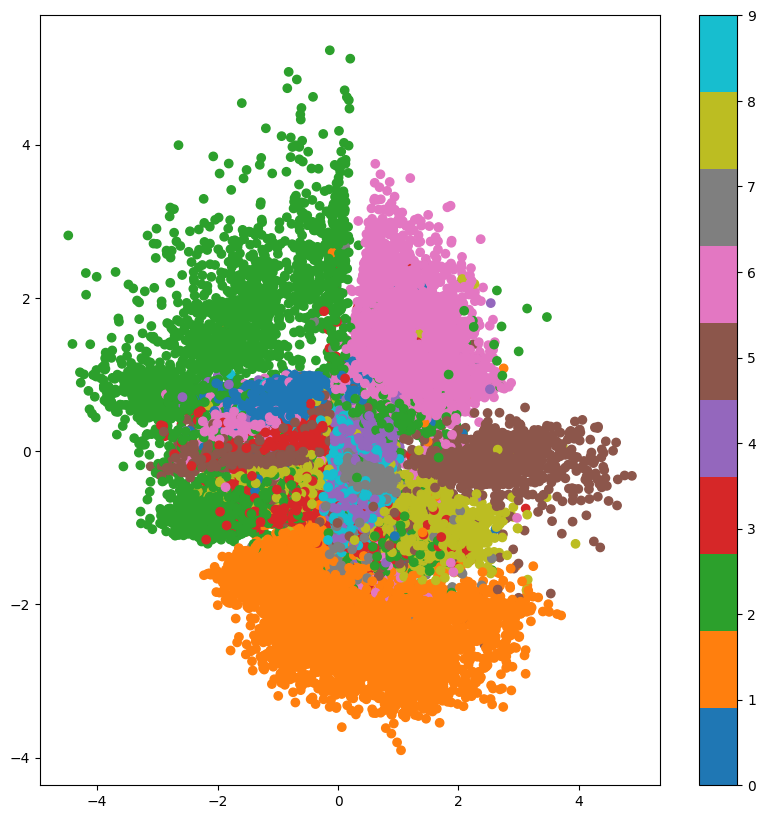

In [28]:
import matplotlib.pyplot as plt
# encode and plot the z values for the train set 
model.eval()
z_all = []
y_all = []
with torch.no_grad():
    for data, target in tqdm(train_loader, desc='Encoding'):
        data = data.to(device)
        output = model(data, compute_loss=False)
        z_all.append(output.z_sample.cpu().numpy())
        y_all.append(target.numpy())

import numpy as np
z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)
plt.figure(figsize=(10, 10))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10')
plt.colorbar()

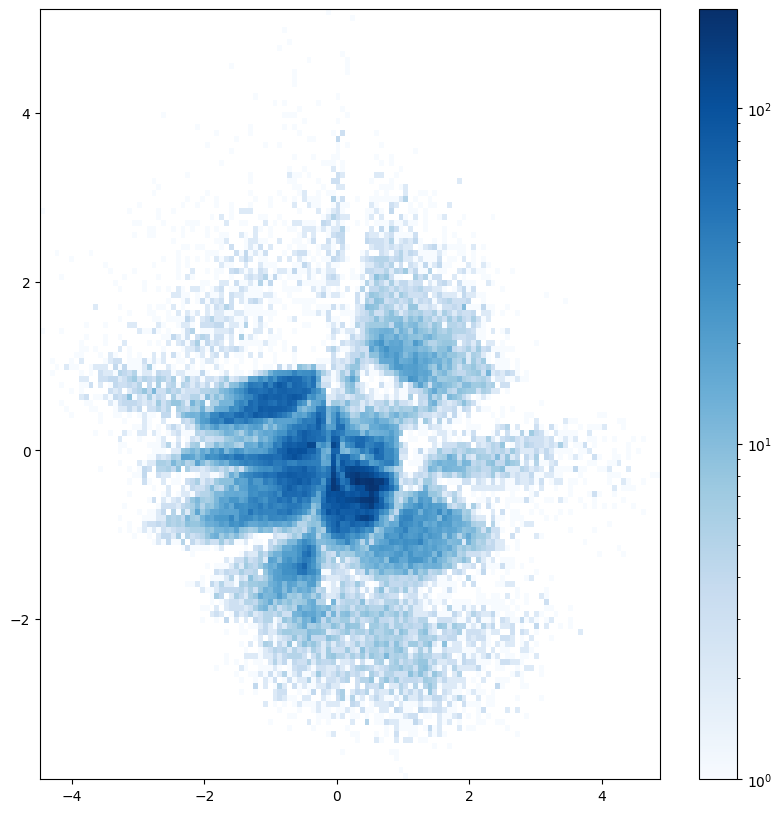

In [29]:
# plot as 2d histogram, log scale
from matplotlib.colors import LogNorm
plt.figure(figsize=(10, 10))
plt.hist2d(z_all[:, 0], z_all[:, 1], bins=128, cmap='Blues', norm=LogNorm())
plt.colorbar()

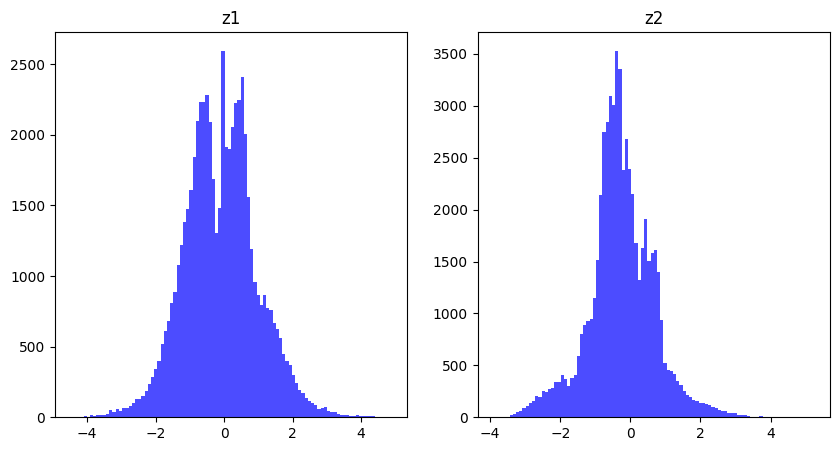

In [30]:
# plot 1d histograms
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(z_all[:, 0], bins=100, color='b', alpha=0.7)
ax[0].set_title('z1')
ax[1].hist(z_all[:, 1], bins=100, color='b', alpha=0.7)
ax[1].set_title('z2')
plt.show()

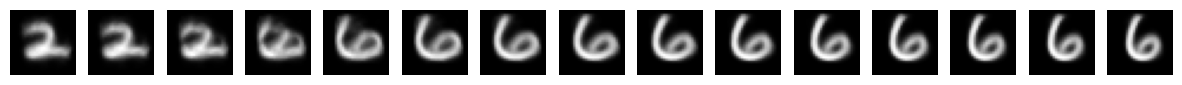

In [31]:
n = 15
z1 = torch.linspace(-0, 1, n)
z2 = torch.zeros_like(z1) + 2
z = torch.stack([z1, z2], dim=-1).to(device)
samples = model.decode(z)
samples = torch.sigmoid(samples)

# Plot the generated images
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    ax[i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[i].axis('off')

In [35]:
z

tensor([[0.0000, 2.0000],
        [0.0714, 2.0000],
        [0.1429, 2.0000],
        [0.2143, 2.0000],
        [0.2857, 2.0000],
        [0.3571, 2.0000],
        [0.4286, 2.0000],
        [0.5000, 2.0000],
        [0.5714, 2.0000],
        [0.6429, 2.0000],
        [0.7143, 2.0000],
        [0.7857, 2.0000],
        [0.8571, 2.0000],
        [0.9286, 2.0000],
        [1.0000, 2.0000]], device='cuda:0')

In [ ]:
18600818222
18210334309